use trained DeepIRES model, and then cluster sequences based on outputs from dense layers in DeepIRES' outputs

In [109]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import logomaker

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score,accuracy_score,recall_score,matthews_corrcoef,confusion_matrix,roc_curve, precision_recall_curve

from model_copy import deepires_model, deepires_early_output
from sequence_encode import get_data_onehot

Load model + weights

In [2]:
# get the early output model version of deepires
model = deepires_early_output()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 174, 4)       20          ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 174, 16)      144         ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 174, 16)      208         ['embedding[0][0]']              
                                                                                             

In [3]:
model.load_weights("../weights/first").expect_partial()

add dataset in X_train and y_train (first cells using preprocessed sequences, and later cells manually preprocessing them)

In [4]:
# get training data to cluster
train = np.load('../dataset/external_testing_dataset/Human5UTR_ires_full.npz')
X_train,y_train = train['X'], train['y']
print(X_train.shape)
print(y_train.shape)


(55000, 174)
(55000,)


In [11]:
print(X_train[:10])
print(X_train.shape)
print(y_train[:10])
print(np.unique(y_train))

[[3 3 2 ... 3 1 3]
 [3 3 4 ... 3 1 3]
 [2 4 3 ... 3 1 3]
 ...
 [2 2 2 ... 3 1 3]
 [3 1 4 ... 3 1 3]
 [2 2 3 ... 3 1 3]]
(55000, 174)
[0 0 0 0 0 0 0 0 0 0]
[0 1]


In [111]:
# encode sequences based on threshold
ACTIVATION_THRESHOLD = 600
active_df = pd.read_csv('../dataset/train/train_set.csv')
# print(active_df.head)
print(active_df.shape)
y_train = np.where(active_df['ires_activity'] >= ACTIVATION_THRESHOLD, 1, 0)
print(y_train.shape)
# print(y_test)

(16674, 14)
(16674,)


In [112]:
sequence_ndarray = np.array(active_df['Sequence'])
print(sequence_ndarray.shape)
reshaped_ndarray = sequence_ndarray.reshape(16674,1)
print(reshaped_ndarray[:5])

# updated_ndarray = get_data_onehot(reshaped_ndarray[0], 174)
# print(updated_ndarray.shape)
# print(updated_ndarray[0])

(16674,)
[['CTAGGGCGCGCCAGTCCTAGACGAGGAATTGGAATACGGGTGGAAGAAATGGGGGAAAACATTGTTTGTCACTCCACCCATGTCCAATAACACATTTGTTGTGGATGGTCCCAAAACAAAAGAATGCCCAGATGAGAATAGAGCCTGGAACAGTTTAGAAGTGGAGGATTTTGGATTTGGGCTAACATCAACCGACTCGGACCGATGGTGAG']
 ['CTAGGGCGCGCCAGTCCTTGGTGCTAGAAGGAGATAGCTGCTTGACAATCATGGCAAACGACAAACCAACATTGGACGTCCGCATGATTAACATCGAAGCTAGCCAACTTGCTGAGGTCAGAAGTTACTGCTATCATGCTTCAGTCACTGACATCTCGACGGTGGCTCGGTGCCCCACGACTGGAGAAGCTCCGACTCGGACCGATGGTGAG']
 ['CTAGGGCGCGCCAGTCCTACACACCCTGACCCGCATCGCCCTGGGTCTCTCGAGCCTGCTGCCTGCTCCCCCGCCCCACCAGCCATGGTGGTTTCTGGAGCGCCCCCAGCCCTGGGTGGGGGCTGTCTCGGCACCTTCACCTCCCTGCTGCTGCTGGCGTCGACAGCCATCCTCAATGCGGCCAGGATACCTCGACTCGGACCGATGGTGAG']
 ['CTAGGGCGCGCCAGTCCTCCGGCTAGTCTTTGGCCGCCGCCGAACCCCGCGCGCCACTCGCTCGCTCAGAGGGAGGAGAAAGTGGCGAGTTCCGGATCCCTGCCTAGCGCGGCCCAACCTTTACTCCAGAGATCATGGCTGCCGAGGATGTGGTGGCGACTGGCGCCGACCCAAGCGATCTGGAGAGCGGCGCGACTCGGACCGATGGTGAG']
 ['CTAGGGCGCGCCAGTCCTAGATCTACAGGGACATGTACTGAGTTCCTTCAGATCAGCCACACCTTTTCCAGGAGTTCTGAAGCTGACAGCACTACAAAGGAGACGGGGGAGCAGCA

In [113]:
results = []

for reshaped_arr in reshaped_ndarray:
    onehot = get_data_onehot(reshaped_arr, 174)
    results.append(onehot[0])

X_train = np.array(results)
print(X_train.shape)
print(X_train[0])

(16674, 174)
[3 3 4 3 3 1 1 3 1 1 1 4 3 3 3 3 3 1 1 1 1 2 1 4 4 3 4 4 4 3 4 2 1 2 4 2 2
 1 2 2 2 1 4 3 4 2 2 1 1 4 1 1 2 1 2 1 4 4 4 3 4 4 3 4 3 3 1 4 3 3 4 2 2 2
 1 1 1 1 2 1 1 1 1 3 1 1 4 3 2 2 2 1 3 1 4 3 1 3 1 1 4 1 3 1 3 2 2 4 3 3 1
 1 2 1 3 4 4 4 1 3 1 1 3 4 3 3 1 3 3 1 4 4 4 4 3 3 1 4 4 4 3 3 3 2 4 1 1 2
 1 4 2 1 1 2 2 3 1 2 4 2 3 3 1 2 2 3 1 4 3 3 4 3 1 3]


Predict outputs and compare results

In [114]:
hidden_output = model.predict(X_train)
print(hidden_output.shape)

522/522 [==============================] - 6s 11ms/step
(16674, 32)


In [115]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(hidden_output)
print(X_embedded.shape)

KeyboardInterrupt: 

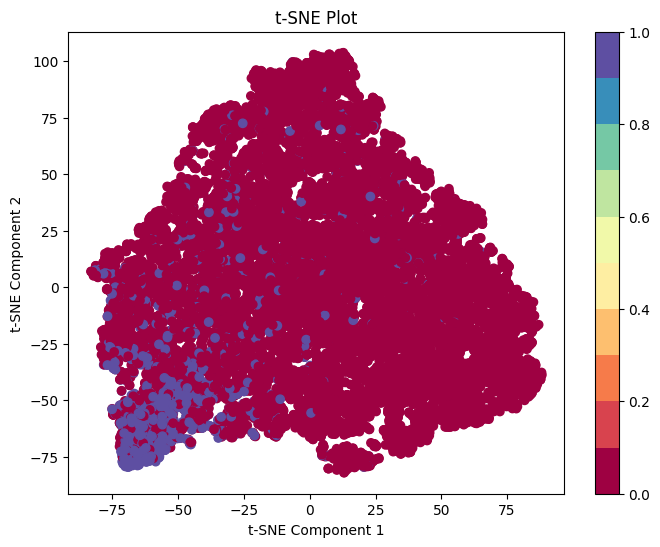

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10))
plt.colorbar()
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

(16674, 2)


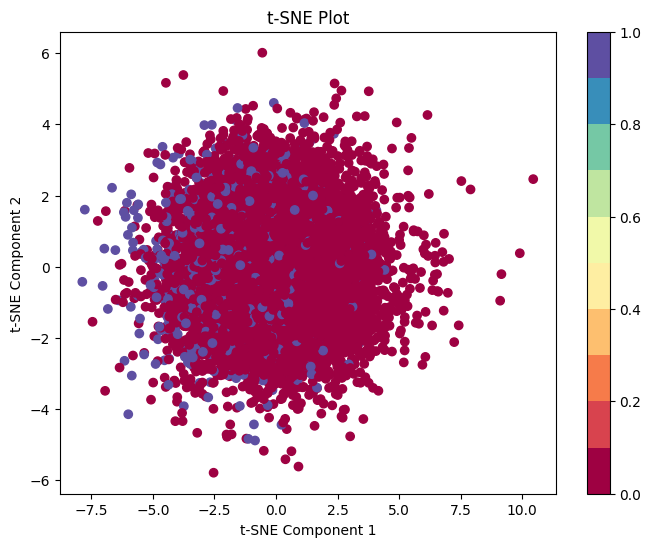

In [ ]:
# X_embedded = PCA(n_components=2).fit_transform(X_train)
# print(X_embedded.shape)
# plt.figure(figsize=(8, 6))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10))
# plt.colorbar()
# plt.title('t-SNE Plot')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.show()

Get section from TSNE analysis

In [ ]:
# create filtering condition of zone of interest
condition = ((X_embedded[:, 0] < -30) & (X_embedded[:, 1] < -30))
# condition = X_embedded[:, 1] > 60
print(np.unique(condition))
print(condition.shape)


[False  True]
(16674,)


In [ ]:
# get the sequence and activation
focus_sequences = sequence_ndarray[condition]
focus_activations = y_train[condition]
print(focus_sequences.shape)
print(focus_sequences[:10])
print(focus_activations.shape)
print(focus_activations[:10])


(1563,)
['CTAGGGCGCGCCAGTCCTCTGGATGTAGGTGCTCAGATGGTTCTCTTTGAGACAGGCTTTATCCTTTGGCTCTCATTTTTTTGATGAGTGTACATGGCATGAGGGACACAGATTCCGCTAGAATTCAAATCCCACTTGTGTATAACCTAGGGCAATGTGCCACATCTCTGCACATCTGTTCATTGTAAGGATCGACTCGGACCGATGGTGAG'
 'CTAGGGCGCGCCAGTCCTAAGAACCCTGGGAACTGCACTGCCATTGACTTTGTGCTAAATCCTAGCGGATTAAATGTCCCTGGGTCGCAAGACTTAACTTCATTTCTGCGCCAGATTGTACGCAGGACCATCACCCTAAGTGCGAAAAACAAACTTATTAATACCTTATTTCATGCGTCAGCTGACTTCGAACGACTCGGACCGATGGTGAG'
 'CTAGGGCGCGCCAGTCCTCTCTGTAACCCAGACTATGTTTGATGTTTATGTTGATACTTTTATGTCTCATTTTGATGTTGATAGAAAGAGTTTTAATAATTTTGTTAACATTGCTCATGCTTCTCTTAGAGAGGGTGTGCAATTAGAAAAGGTTTTAGATACTTTTGTGGGATGTGTACGTAAATGTTGTTCCGACTCGGACCGATGGTGAG'
 'CTAGGGCGCGCCAGTCCTTGATTTCTAGTTATTTATTCTGGGAATGTATAGTATTTGAAAACAGAAATTGGTACCTTGCACACATCATCTGTAAGCTGTTTGGTTTTAAAATACTGTAGATAATTAACCAAGGTAGAATGACCTTGTAATGTAACTGCTCTTGGGCAATATTCTCTGTACATATTAGCGACACGACTCGGACCGATGGTGAG'
 'CTAGGGCGCGCCAGTCCTAGGAAGGGCAGAGAATGGCTGGGTCAGGGCCAGACTGGAAGACACTTCAGATCTGAGGTTGGATTTGCTCATTGCTGTACCACATCTGCTCTAGGGAATCTGGATTAT

In [ ]:
# save to new csv using pandas
df = pd.DataFrame({"Sequence":focus_sequences, "active": focus_activations})
df.head
df.to_csv(f"../data_subsets/{ACTIVATION_THRESHOLD}.csv", index=False)

Information plot of characters at sequences based on RNA

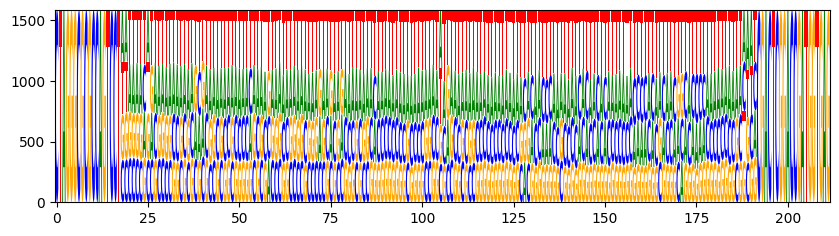

In [117]:
# Create a DataFrame with sequence positions as rows and nucleotides as columns
# Convert the sequences into a DataFrame where each sequence is a row
activation_sequences = pd.read_csv("../data_subsets/207.csv")["Sequence"]
nucleotide_freqs = logomaker.alignment_to_matrix(activation_sequences, to_type='counts')

# Plot the sequence logo
logomaker.Logo(nucleotide_freqs, color_scheme='classic')